In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath('.')))

from utils.sql import *
from utils.vis import *
from utils.tsa import *

import pandas as pd
import numpy

import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
df_info, df_chart, vital_ref_dict, selected_items = load_data()
item_vital = selected_items['vital']
item_resp = selected_items['resp']
item_lab = selected_items['lab']
item_treat = selected_items['treatment']
item_pain = selected_items['pain']

# Vital sign level dependence on patient information

In [3]:
info_normalized = df_info.copy()

age_max = info_normalized['age'].max()
age_min = info_normalized['age'].min()
info_normalized['age'] = (info_normalized['age'] - age_min) / (age_max - age_min)

weight_max = info_normalized['admission_weight'].max()
weight_min = info_normalized['admission_weight'].min()
info_normalized['admission_weight'] = (info_normalized['admission_weight'] - weight_min) / (weight_max - weight_min)
info_normalize_param = {
    'age': [age_min, age_max],
    'weight': [weight_min, weight_max],
}

info_normalized.gender = pd.Categorical(info_normalized.gender)
info_normalized.admission_type = pd.Categorical(info_normalized.admission_type)
info_normalized.admission_location = pd.Categorical(info_normalized.admission_location)
info_normalized.discharge_location = pd.Categorical(info_normalized.discharge_location)

chart_normalized = df_chart.copy()
chart_normalize_param = {}
for iid in item_vital:
    if item_dict[item_dict['itemid']==iid]['param_type'].item() == 'Text':
        cat_item = pd.Categorical(chart_normalized[chart_normalized['itemid']==iid]['value'])
        chart_normalized.loc[chart_normalized['itemid']==iid, 'valuenum'] = cat_item.codes
    else:
#         chart_normalize_param[iid] = [chart_normalized[chart_normalized['itemid']==iid]['valuenum'].min(),
#                                       chart_normalized[chart_normalized['itemid']==iid]['valuenum'].max()]
        
#         d = chart_normalized[chart_normalized['itemid']==iid]['valuenum']
#         d = (d - chart_normalize_param[iid][0]) / (chart_normalize_param[iid][1] - chart_normalize_param[iid][0]) 
        chart_normalize_param[iid] = [chart_normalized[chart_normalized['itemid']==iid]['valuenum'].mean(),
                                      chart_normalized[chart_normalized['itemid']==iid]['valuenum'].std()]
        
        d = chart_normalized[chart_normalized['itemid']==iid]['valuenum']
        d = (d - chart_normalize_param[iid][0]) / chart_normalize_param[iid][1] 
        chart_normalized.loc[chart_normalized['itemid']==iid, 'valuenum'] = d
        
for iid in vital_ref_dict['itemid']:
    if 'HR' in item_dict[item_dict['itemid']==iid]['label'].item():
        d = chart_normalized[chart_normalized['itemid']==iid]['valuenum']
        d = (d - chart_normalize_param[220045][0]) / chart_normalize_param[220045][1] 
    elif 'BPs' in item_dict[item_dict['itemid']==iid]['label'].item():
        d = chart_normalized[chart_normalized['itemid']==iid]['valuenum']
        d = (d - chart_normalize_param[220179][0]) / chart_normalize_param[220179][1] 
    elif 'BPd' in item_dict[item_dict['itemid']==iid]['label'].item():
        d = chart_normalized[chart_normalized['itemid']==iid]['valuenum']
        d = (d - chart_normalize_param[220180][0]) / chart_normalize_param[220180][1] 
    else:
        raise AssertionError(f'itemid{iid} not found in selected orthostatic vital signs.')
    chart_normalized.loc[chart_normalized['itemid']==iid, 'valuenum'] = d

In [4]:
def denorm_data(data, data_source, param, iid=None):
    if data_source in ['age', 'weight']:
        return data * (param[data_source][1] - param[data_source][0]) + param[data_source][0]
    elif data_source in ['chart']:
        return data * param[iid][1] + param[iid][0]
    else:
        raise AssertionError(f'Input data source: {data_source}. Supported data source: "age", "weight", "chart"')

In [5]:
# X: age, gender, weight, admission_type
X_info = np.empty((0, 4))


for adm in info_normalized['hadm_id']:
    info = info_normalized[info_normalized['hadm_id']==adm]
    x = [info['age'].item(), 
         info['gender'].cat.codes.item(), 
         info['admission_weight'].item(), 
         info['admission_type'].cat.codes.item()]
    X_info = np.vstack((X_info, x))
    
vs_avg = {iid:[] for iid in  item_vital}
for adm in info_normalized['hadm_id']:
    for iid in item_vital:
        if item_dict[item_dict['itemid']==iid]['param_type'].item() == 'Text':
            continue
        d = chart_normalized[(df_chart['hadm_id']==adm) & (chart_normalized['itemid']==iid)]['valuenum']
        if d.shape[0] > 3:
            d = d[(d>=d.quantile(0.05)) & (d<=d.quantile(0.95))]
        vs_avg[iid].append(d.mean())
vs_avg = {iid: np.array(vs_avg[iid]) for iid in vs_avg}

In [6]:
cols = ['age', 'gender', 'weight', 'admission_type', 'HR', 'BPs', 'BPd', 'BPm', 'Temperature']
df_vs_avg = pd.DataFrame(columns=cols)
for i in range(X_info.shape[0]):
    d = X_info[i].tolist()
    for iid in [k for k in vs_avg if vs_avg[k].shape[0]!=0]:
        d.append(vs_avg[iid][i])
    df_vs_avg.loc[len(df_vs_avg)] = d
df_vs_avg

,age,gender,weight,admission_type,HR,BPs,BPd,BPm,Temperature
0,0.422535,1.0,0.496418,3.0,-0.335952,-0.901929,-0.547081,-0.229884,-0.015508
1,0.746479,0.0,0.117120,2.0,-0.101599,-0.647155,-0.354004,-0.117997,-0.018958
2,0.859155,0.0,0.312321,2.0,-0.387422,-0.537365,-0.654440,-0.206009,-0.049320
3,0.577465,1.0,0.553725,2.0,0.173206,-0.016021,-0.040137,0.013084,-0.015508
4,0.830986,0.0,0.345272,3.0,0.012196,-0.181014,-0.399703,-0.076630,0.041766
...,...,...,...,...,...,...,...,...,...
271,0.830986,1.0,0.345272,2.0,-0.838644,-0.781677,-0.001574,-0.127828,-0.057371
272,0.873239,0.0,0.300143,2.0,-0.260596,-0.992572,-0.729215,-0.286825,-0.048003
273,0.535211,1.0,0.975645,5.0,-0.319320,-0.455736,-1.066355,-0.301789,-0.042420
274,0.492958,1.0,0.354585,2.0,0.266576,-0.146711,0.173677,-0.021372,0.005883


0.03420198821524245


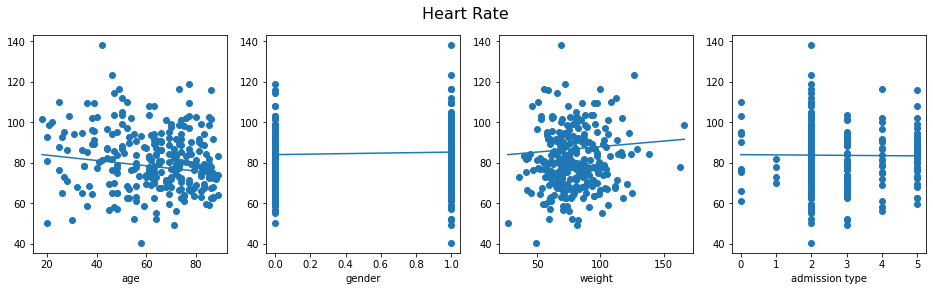

In [7]:
from sklearn.linear_model import LinearRegression, Lasso

# HR

iid = 220045

reg = LinearRegression()
reg.fit(X_info, vs_avg[iid])
print(reg.score(X_info, vs_avg[iid]))

fig = plt.figure(figsize=(16,4))
fig.suptitle(f'{item_dict[item_dict["itemid"]==iid]["label"].item()}', fontsize=16)
gs = gridspec.GridSpec(1, 4) 

for i, ilabel in enumerate(['age', 'gender', 'weight', 'admission type']):
    
    x_pred = np.linspace(X_info[:,i].min(), X_info[:,i].max(), 100)
    y_pred = reg.coef_[i] * x_pred + reg.intercept_
    
    if ilabel in ['age', 'weight']:
        x = denorm_data(X_info[:,i], ilabel, info_normalize_param)
        x_pred = denorm_data(x_pred, ilabel, info_normalize_param)
    else: 
        x = X_info[:,i]
             
    y = denorm_data(vs_avg[iid], 'chart', chart_normalize_param, iid)
    y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, iid)
    
    ax = plt.subplot(gs[i])
    ax.scatter(x, y)
    ax.plot(x_pred, y_pred)
    ax.set_xlabel(f'{ilabel}')

0.021548045973031726


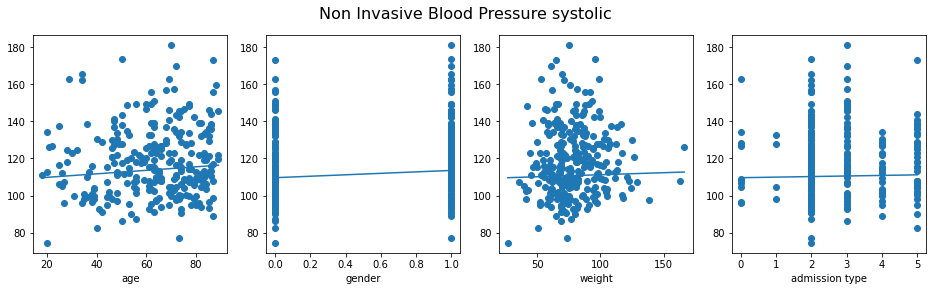

In [8]:
# BPS

iid = 220179

reg = LinearRegression()
reg.fit(X_info, vs_avg[iid])
print(reg.score(X_info, vs_avg[iid]))

fig = plt.figure(figsize=(16,4))
fig.suptitle(f'{item_dict[item_dict["itemid"]==iid]["label"].item()}', fontsize=16)
gs = gridspec.GridSpec(1, 4) 

for i, ilabel in enumerate(['age', 'gender', 'weight', 'admission type']):
    
    x_pred = np.linspace(X_info[:,i].min(), X_info[:,i].max(), 100)
    y_pred = reg.coef_[i] * x_pred + reg.intercept_
    
    if ilabel in ['age', 'weight']:
        x = denorm_data(X_info[:,i], ilabel, info_normalize_param)
        x_pred = denorm_data(x_pred, ilabel, info_normalize_param)
    else: 
        x = X_info[:,i]
             
    y = denorm_data(vs_avg[iid], 'chart', chart_normalize_param, iid)
    y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, iid)
    
    if i == 0:
        ax.set_ylabel(f'{item_dict[item_dict["itemid"]==iid]["label"].item()}')
    ax = plt.subplot(gs[i])
    ax.scatter(x, y)
    ax.plot(x_pred, y_pred)
    ax.set_xlabel(f'{ilabel}')

0.040205824555320624


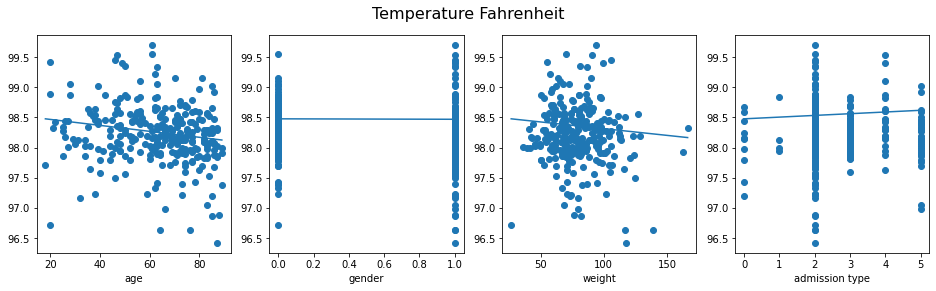

In [9]:
# Temperature

iid = 223761

reg = LinearRegression()
reg.fit(X_info, vs_avg[iid])
print(reg.score(X_info, vs_avg[iid]))

fig = plt.figure(figsize=(16,4))
fig.suptitle(f'{item_dict[item_dict["itemid"]==iid]["label"].item()}', fontsize=16)
gs = gridspec.GridSpec(1, 4) 

for i, ilabel in enumerate(['age', 'gender', 'weight', 'admission type']):
    
    x_pred = np.linspace(X_info[:,i].min(), X_info[:,i].max(), 100)
    y_pred = reg.coef_[i] * x_pred + reg.intercept_
    
    if ilabel in ['age', 'weight']:
        x = denorm_data(X_info[:,i], ilabel, info_normalize_param)
        x_pred = denorm_data(x_pred, ilabel, info_normalize_param)
    else: 
        x = X_info[:,i]
             
    y = denorm_data(vs_avg[iid], 'chart', chart_normalize_param, iid)
    y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, iid)

    ax = plt.subplot(gs[i])
    ax.scatter(x, y)
    ax.plot(x_pred, y_pred)
    ax.set_xlabel(f'{ilabel}')

# Orthostatic vital sign dependence on patient information

In [10]:
X_info = {}
y_ref = {}

for iid in vital_ref_dict['itemid']:
    
    x = np.empty((0, 4))
    y = []
    
    for adm in chart_normalized[chart_normalized['itemid']==iid]['hadm_id']:
        info = info_normalized[info_normalized['hadm_id']==adm]
        
        for ref in chart_normalized[(chart_normalized['itemid']==iid) 
                                    & (chart_normalized['hadm_id']==adm)]['valuenum']:
            x_ = [info['age'].item(), 
                 info['gender'].cat.codes.item(), 
                 info['admission_weight'].item(), 
                 info['admission_type'].cat.codes.item()]
            x = np.vstack((x, x_))

            y.append(ref)
    
    
    X_info[iid] = x
    y_ref[iid] = np.array(y)

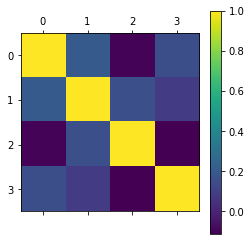

In [11]:
plt.matshow(pd.DataFrame(X_info[iid], columns=['age', 'gender', 'weight', 'admission']).corr())
plt.colorbar()

In [12]:
from sklearn.linear_model import Ridge

In [13]:
item_vital

{220045: 'Heart Rate',
 220048: 'Heart Rhythm',
 220179: 'Non Invasive Blood Pressure systolic',
 220180: 'Non Invasive Blood Pressure diastolic',
 220181: 'Non Invasive Blood Pressure mean',
 223761: 'Temperature Fahrenheit',
 224642: 'Temperature Site',
 224650: 'Ectopy Type 1',
 224651: 'Ectopy Frequency 1'}

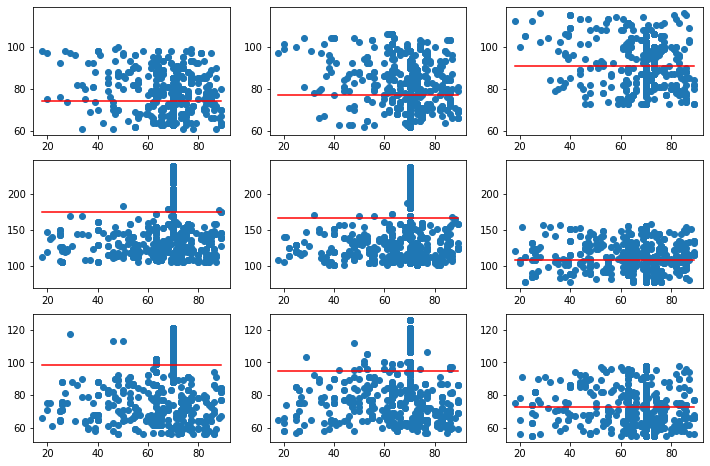

In [14]:
ref_iid = [
    {
        223764: 'HR lying',
        223765: 'HR sitting',
        224647: 'HR standing',
    },
    {
        224645: 'BPs lying',
        224646: 'BPs sitting',
        223766: 'BPs standing',
    },
    {
        226092: 'BPd lying',
        226094: 'BPd sitting',
        226096: 'BPd standing',    
    }
]

denorm_param = {
    0: 220045,
    1: 220179,
    2: 220180,
}
ylim = {
    0: [30, 150]
}

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,3)

for j, refs in enumerate(ref_iid):
    for i, iid in enumerate(refs):
        ax = plt.subplot(gs[j,i], sharey=plt.subplot(gs[j,0]))

        x = X_info[iid][:, 0].reshape(-1, 1)
        y = y_ref[iid]
        idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
        x = x[idx]
        y = y[idx]

    #     reg = LinearRegression().fit(x, y)
        reg = Lasso().fit(x, y)
        x_pred = np.array([X_info[iid][:,0].min(), X_info[iid][:,0].max()]).reshape(-1,1)
        y_pred = reg.coef_[0] * x_pred + reg.intercept_

#         x = denorm_data(X_info[iid][:,0], 'age', info_normalize_param)
#         y = denorm_data(y_ref[iid], 'chart', chart_normalize_param, 220045)
        x = denorm_data(x, 'age', info_normalize_param)
        y = denorm_data(y, 'chart', chart_normalize_param, denorm_param[j])
        x_pred = denorm_data(x_pred, 'age', info_normalize_param)
        y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])
        ax.scatter(x, y)
        ax.plot(x_pred, y_pred, c='r')
#         ax.set_ylim([0, 200])

    #     print(reg.score(x, y))

In [15]:
def get_binned_mean(x, y, n_bins=20):
    x_ = []
    y_ = []

#     x_bin = np.linspace(x.min(), x.max(), 20)
#     for i in range(len(x_bin)-1):
#         idx = np.where(np.logical_and(x>x_bin[i], x<x_bin[i+1]))
#         print(idx)
#         x_.append((x_bin[i] + x_bin[i+1]) / 2)
#         y_.append(y[idx].mean())

    step = (x.max() - x.min()) / (n_bins - 1)
    x1 = x.min()
    x2 = x1 + step
    while x2 < x.max():
        idx = np.where(np.logical_and(x>x1, x<x2))[0]
        if len(idx) == 0:
            x2 += step
            continue
#         print(idx)
        x_.append((x1 + x2) / 2)
        y_.append(y[idx].mean())
        
        x1 += step
        x2 += step
        
    return np.array(x_), np.array(y_)

def get_binned_median(x, y, n_bins=20):
    x_ = []
    y_ = []
#     x_bin = np.linspace(x.min(), x.max(), 20)
#     for i in range(len(x_bin)-1):
#         idx = np.where(np.logical_and(x>x_bin[i], x<x_bin[i+1]))
#         x_.append((x_bin[i] + x_bin[i+1]) / 2)
#         y_.append(np.median(y[idx]))
    step = (x.max() - x.min()) / (n_bins - 1)
    x1 = x.min()
    x2 = x1 + step
    while x2 < x.max():
        idx = np.where(np.logical_and(x>x1, x<x2))[0]
        if len(idx) == 0:
            x2 += step
            continue
#         print(idx)
        x_.append((x1 + x2) / 2)
        y_.append(np.median(y[idx]))
        
        x1 += step
        x2 += step
        
    return np.array(x_), np.array(y_)

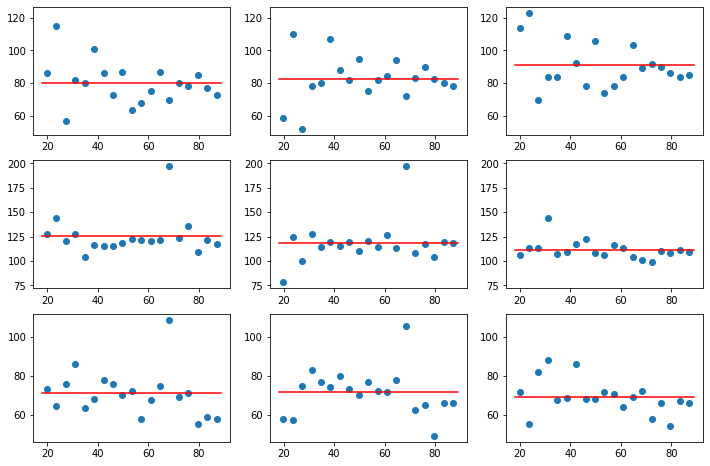

In [16]:
# Handle unbalanced sampling over x axis
# Use mean value of binned data

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,3)

for j, refs in enumerate(ref_iid):
    for i, iid in enumerate(refs):
        ax = plt.subplot(gs[j,i], sharey=plt.subplot(gs[j,0]))

        x = X_info[iid][:, 0]
        y = y_ref[iid]
        idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
        x, y = get_binned_median(x, y)

    #     reg = LinearRegression().fit(x, y)
        reg = Lasso().fit(x.reshape(-1, 1), y)
        x_pred = np.array([X_info[iid][:,0].min(), X_info[iid][:,0].max()]).reshape(-1,1)
        y_pred = reg.coef_[0] * x_pred + reg.intercept_

#         x = denorm_data(X_info[iid][:,0], 'age', info_normalize_param)
#         y = denorm_data(y_ref[iid], 'chart', chart_normalize_param, 220045)
        x = denorm_data(x, 'age', info_normalize_param)
        y = denorm_data(y, 'chart', chart_normalize_param, denorm_param[j])
        x_pred = denorm_data(x_pred, 'age', info_normalize_param)
        y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])
        ax.scatter(x, y)
        ax.plot(x_pred, y_pred, c='r')
#         ax.set_ylim([0, 200])

    #     print(reg.score(x, y))

In [17]:
from sklearn.linear_model import HuberRegressor, RANSACRegressor, SGDRegressor

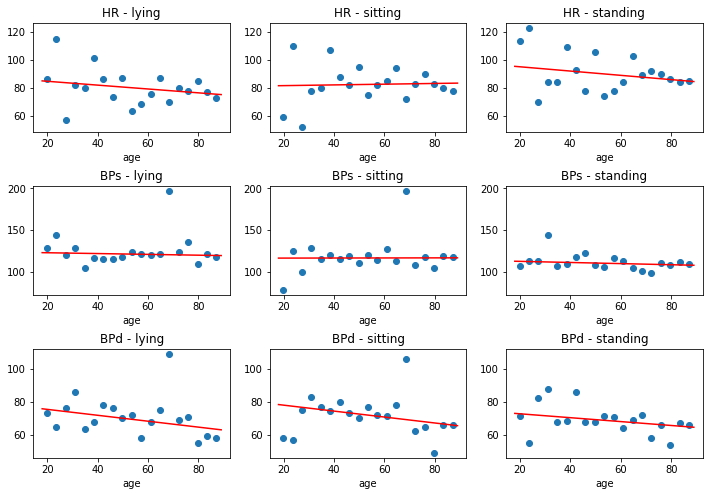

In [28]:
# Handle unbalanced sampling over x axis
# Use mean value of binned data
title_i = ['lying', 'sitting', 'standing']
title_j = ['HR', 'BPs', 'BPd']

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.5)
gs = gridspec.GridSpec(3,3)

for j, refs in enumerate(ref_iid):
    for i, iid in enumerate(refs):
        ax = plt.subplot(gs[j,i], sharey=plt.subplot(gs[j,0]))
        ax.set_title(f'{title_j[j]} - {title_i[i]}')
        ax.set_xlabel('age')
        
        x = X_info[iid][:, 0]
        y = y_ref[iid]
        idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
        x, y = get_binned_median(x, y)

    #     reg = LinearRegression().fit(x, y)
        reg = HuberRegressor().fit(x.reshape(-1, 1), y)
        x_pred = np.linspace(X_info[iid][:,0].min(), X_info[iid][:,0].max(), 100) 
#         np.array([X_info[iid][:,0].min(), X_info[iid][:,0].max()]).reshape(-1,1)
#         y_pred = reg.coef_[0] * x_pred + reg.intercept_
        y_pred = reg.predict(x_pred.reshape(-1,1))

#         x = denorm_data(X_info[iid][:,0], 'age', info_normalize_param)
#         y = denorm_data(y_ref[iid], 'chart', chart_normalize_param, 220045)
        x = denorm_data(x, 'age', info_normalize_param)
        y = denorm_data(y, 'chart', chart_normalize_param, denorm_param[j])
        x_pred = denorm_data(x_pred, 'age', info_normalize_param)
        y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])
        ax.scatter(x, y)
        ax.plot(x_pred, y_pred, c='r')
#         ax.set_ylim([0, 200])

    #     print(reg.score(x, y))

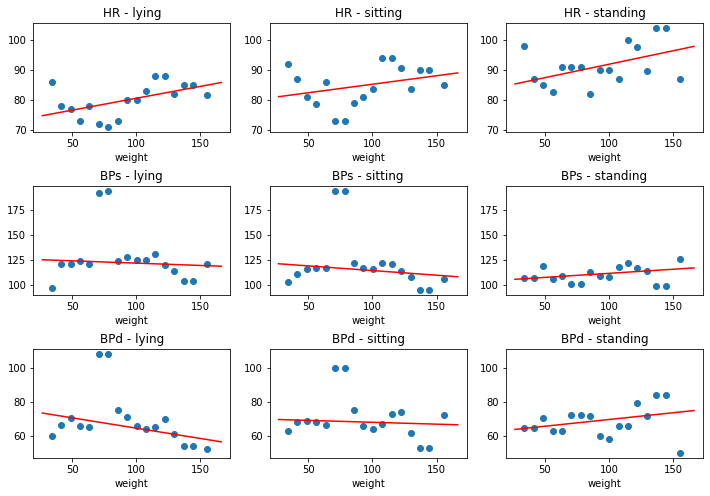

In [29]:
# Handle unbalanced sampling over x axis
# Use median value of binned data

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.5)
gs = gridspec.GridSpec(3,3)

for j, refs in enumerate(ref_iid):
    for i, iid in enumerate(refs):
        ax = plt.subplot(gs[j,i], sharey=plt.subplot(gs[j,0]))
        ax.set_title(f'{title_j[j]} - {title_i[i]}')
        ax.set_xlabel('weight')

        x = X_info[iid][:, 2]
        y = y_ref[iid]
        idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
        x, y = get_binned_median(x, y)

    #     reg = LinearRegression().fit(x, y)
        reg = HuberRegressor().fit(x.reshape(-1, 1), y)
        x_pred = np.array([X_info[iid][:,0].min(), X_info[iid][:,0].max()]).reshape(-1,1)
        y_pred = reg.coef_[0] * x_pred + reg.intercept_

#         x = denorm_data(X_info[iid][:,0], 'age', info_normalize_param)
#         y = denorm_data(y_ref[iid], 'chart', chart_normalize_param, 220045)
        x = denorm_data(x, 'weight', info_normalize_param)
        y = denorm_data(y, 'chart', chart_normalize_param, denorm_param[j])
        x_pred = denorm_data(x_pred, 'weight', info_normalize_param)
        y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])
        ax.scatter(x, y)
        ax.plot(x_pred, y_pred, c='r')
#         ax.set_ylim([0, 200])

    #     print(reg.score(x, y))

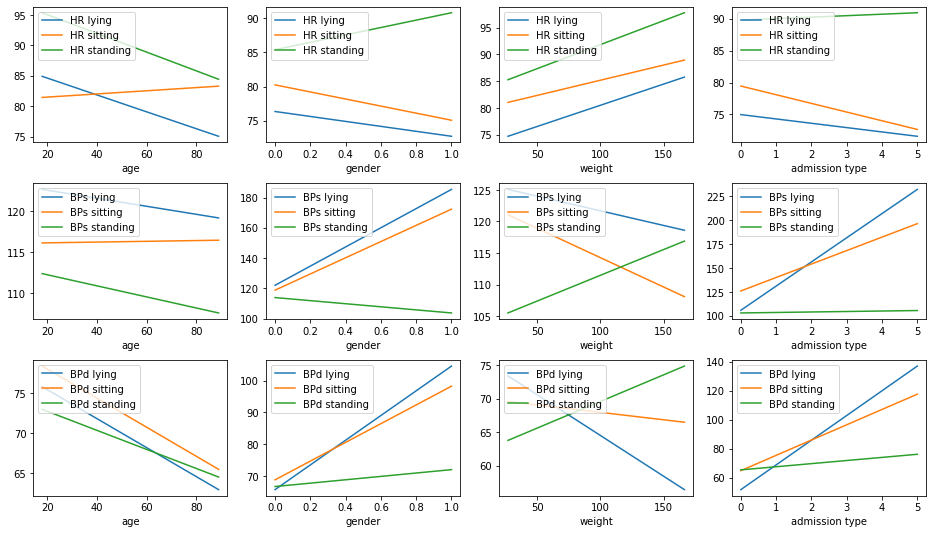

In [30]:
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(hspace=0.3)
gs = gridspec.GridSpec(3,4)

for j, refs in enumerate(ref_iid):
    for iid in refs:
        for i, ilabel in enumerate(['age', 'gender', 'weight', 'admission type']):
            ax = plt.subplot(gs[j,i])
            
            x = X_info[iid][:, i]
            y = y_ref[iid]
            idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
            
            if ilabel in ['age', 'weight']:
                x, y = get_binned_median(x, y)
            
#             reg = LinearRegression().fit(X_info[iid][:,i].reshape(-1,1), y_ref[iid])
            reg = HuberRegressor().fit(x.reshape(-1,1), y)

            x_pred = np.array([X_info[iid][:,i].min(), X_info[iid][:,i].max()]).reshape(-1,1)
            y_pred = reg.coef_ * x_pred + reg.intercept_

            if ilabel in ['age', 'weight']:
                x_pred = denorm_data(x_pred, ilabel, info_normalize_param)

            y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])

            ax.plot(x_pred, y_pred, label=f'{refs[iid]}')
            ax.set_xlabel(f'{ilabel}')
            plt.legend(loc='upper left')

# Probablistic modeling of vital sign levels

In [7]:
from functools import partial
import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
pyro.set_rng_seed(1)

In [8]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 10.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [9]:
df = df_vs_avg[['age', 'HR']].copy()
# df['interact'] = df_vs_avg['age'] * df_vs_avg['HR']
# df = df[['age', 'interact', 'HR']]
data = torch.tensor(df.values, dtype=torch.float32)
x_data, y_data = data[:, :-1], data[:, -1]
    
num_iterations=2000

model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 7.9405
[iteration 0201] loss: 1.3460
[iteration 0401] loss: 1.2328
[iteration 0601] loss: 1.2259
[iteration 0801] loss: 1.1765
[iteration 1001] loss: 1.1662
[iteration 1201] loss: 1.1523
[iteration 1401] loss: 1.1352
[iteration 1601] loss: 1.1284
[iteration 1801] loss: 1.1315


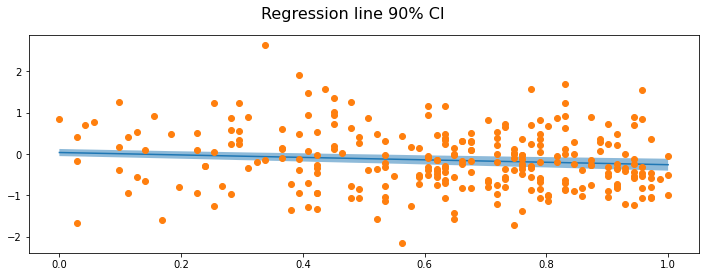

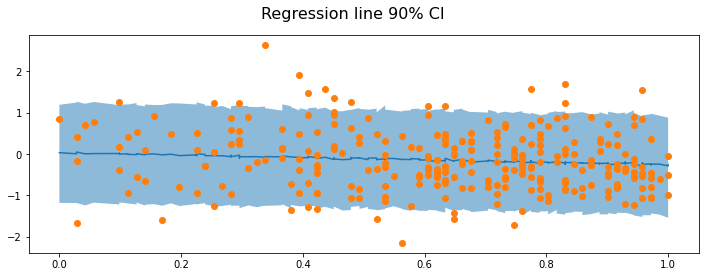

In [10]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "age": x_data[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_gt": y_data,
})

fig, ax = plt.subplots(figsize=(12, 4),)
predictions = predictions.sort_values(by=['age'])

fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['age'], predictions['mu_mean'])
ax.fill_between(predictions['age'],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)
ax.plot(predictions["age"],
        predictions["y_gt"],
        "o")


fig, ax = plt.subplots(figsize=(12, 4),)
predictions = predictions.sort_values(by=['age'])

fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['age'], predictions['y_mean'])
ax.fill_between(predictions['age'],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
ax.plot(predictions["age"],
        predictions["y_gt"],
        "o")

In [38]:
df = df_vs_avg[['weight', 'HR']].copy()
# df['interact'] = df_vs_avg['age'] * df_vs_avg['HR']
# df = df[['age', 'interact', 'HR']]
data = torch.tensor(df.values, dtype=torch.float32)
x_data, y_data = data[:, :-1], data[:, -1]
    
num_iterations=2000

model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.4375
[iteration 0201] loss: 1.3060
[iteration 0401] loss: 1.2060
[iteration 0601] loss: 1.1757
[iteration 0801] loss: 1.1665
[iteration 1001] loss: 1.1629
[iteration 1201] loss: 1.1483
[iteration 1401] loss: 1.1375
[iteration 1601] loss: 1.1339
[iteration 1801] loss: 1.1349


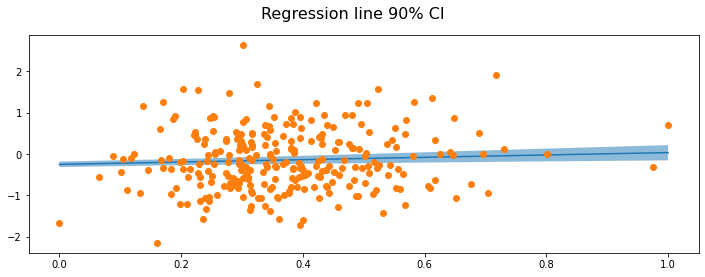

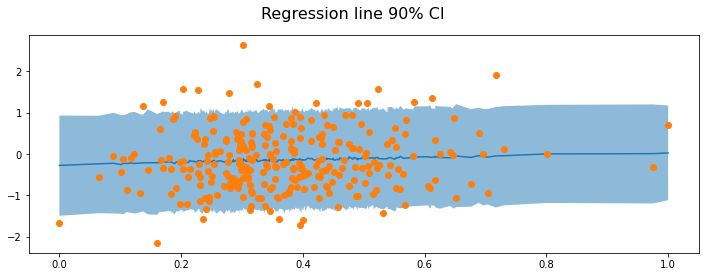

In [40]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "weight": x_data[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_gt": y_data,
})

fig, ax = plt.subplots(figsize=(12, 4),)
predictions = predictions.sort_values(by=['weight'])

fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['weight'], predictions['mu_mean'])
ax.fill_between(predictions['weight'],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)
ax.plot(predictions["weight"],
        predictions["y_gt"],
        "o")


fig, ax = plt.subplots(figsize=(12, 4),)
fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['weight'], predictions['y_mean'])
ax.fill_between(predictions['weight'],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
ax.plot(predictions["weight"],
        predictions["y_gt"],
        "o")

In [35]:
# multivariate regression - age, weight, gender, admission_type

df = df_vs_avg[['age', 'weight', 'gender', 'admission_type', 'HR']].copy()
# df['interact'] = df_vs_avg['age'] * df_vs_avg['HR']
# df = df[['age', 'interact', 'HR']]
data = torch.tensor(df.values, dtype=torch.float32)
x_data, y_data = data[:, :-1], data[:, -1]
    
num_iterations=5000

model = BayesianRegression(4, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 232.4246
[iteration 0201] loss: 28.5486
[iteration 0401] loss: 15.8248
[iteration 0601] loss: 12.7435
[iteration 0801] loss: 9.7986
[iteration 1001] loss: 8.3064
[iteration 1201] loss: 6.4390
[iteration 1401] loss: 5.3799
[iteration 1601] loss: 4.3287
[iteration 1801] loss: 3.8206
[iteration 2001] loss: 3.3390
[iteration 2201] loss: 2.6699
[iteration 2401] loss: 2.1916
[iteration 2601] loss: 2.1093
[iteration 2801] loss: 1.8559
[iteration 3001] loss: 1.6696
[iteration 3201] loss: 1.5605
[iteration 3401] loss: 1.4537
[iteration 3601] loss: 1.4212
[iteration 3801] loss: 1.3718
[iteration 4001] loss: 1.2982
[iteration 4201] loss: 1.3236
[iteration 4401] loss: 1.2898
[iteration 4601] loss: 1.2531
[iteration 4801] loss: 1.2329


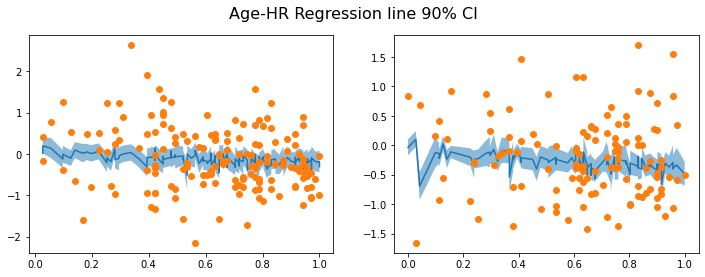

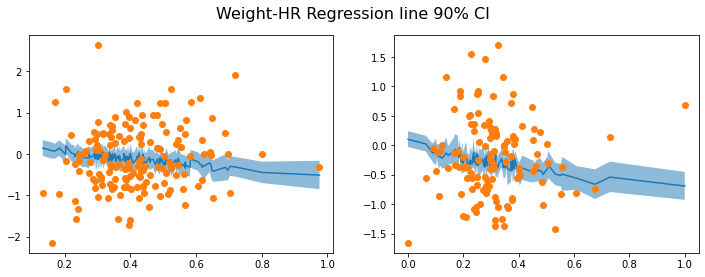

In [36]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "age": x_data[:, 0],
    "weight": x_data[:, 1],
    "gender": x_data[:, 2],
    "admission_type": x_data[:, 3],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_gt": y_data,
})


male_pred = predictions[predictions['gender']==1].sort_values(by=['age'])
female_pred = predictions[predictions['gender']==0].sort_values(by=['age'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
for i, pred in enumerate([male_pred, female_pred]):
    fig.suptitle("Age-HR Regression line 90% CI", fontsize=16)
    ax[i].plot(pred['age'], pred['mu_mean'])
    ax[i].fill_between(pred['age'],
                       pred["mu_perc_5"],
                       pred["mu_perc_95"],
                       alpha=0.5)
    ax[i].plot(pred["age"], pred["y_gt"], "o")


male_pred = male_pred.sort_values(by=['weight'])
female_pred = female_pred.sort_values(by=['weight'])
fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
for i, pred in enumerate([male_pred, female_pred]):
    fig.suptitle("Weight-HR Regression line 90% CI", fontsize=16)
    ax[i].plot(pred['weight'], pred['mu_mean'])
    ax[i].fill_between(pred['weight'],
                       pred["mu_perc_5"],
                       pred["mu_perc_95"],
                       alpha=0.5)
    ax[i].plot(pred["weight"], pred["y_gt"], "o")

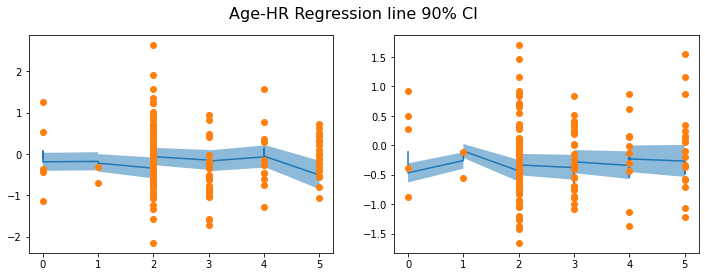

In [37]:
male_pred = predictions[predictions['gender']==1].sort_values(by=['admission_type'])
female_pred = predictions[predictions['gender']==0].sort_values(by=['admission_type'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
for i, pred in enumerate([male_pred, female_pred]):
    fig.suptitle("Age-HR Regression line 90% CI", fontsize=16)
    ax[i].plot(pred['admission_type'], pred['mu_mean'])
    ax[i].fill_between(pred['admission_type'],
                       pred["mu_perc_5"],
                       pred["mu_perc_95"],
                       alpha=0.5)
    ax[i].plot(pred["admission_type"], pred["y_gt"], "o")



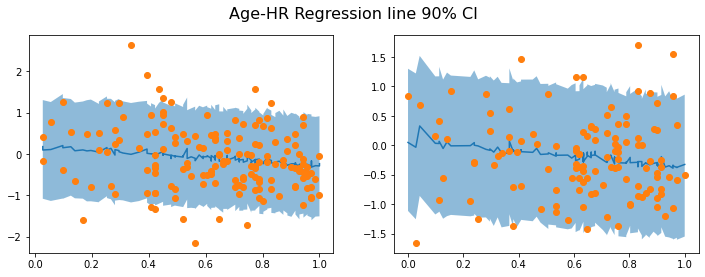

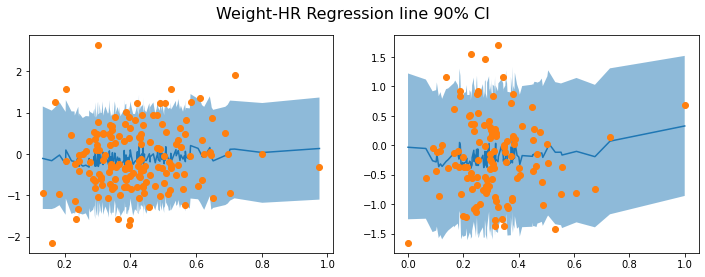

In [100]:
male_pred = predictions[predictions['gender']==1].sort_values(by=['age'])
female_pred = predictions[predictions['gender']==0].sort_values(by=['age'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
for i, pred in enumerate([male_pred, female_pred]):
    fig.suptitle("Age-HR Regression line 90% CI", fontsize=16)
    ax[i].plot(pred['age'], pred['mu_mean'])
    ax[i].fill_between(pred['age'],
                       pred["y_perc_5"],
                       pred["y_perc_95"],
                       alpha=0.5)
    ax[i].plot(pred["age"], pred["y_gt"], "o")


male_pred = male_pred.sort_values(by=['weight'])
female_pred = female_pred.sort_values(by=['weight'])
fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
for i, pred in enumerate([male_pred, female_pred]):
    fig.suptitle("Weight-HR Regression line 90% CI", fontsize=16)
    ax[i].plot(pred['weight'], pred['mu_mean'])
    ax[i].fill_between(pred['weight'],
                       pred["y_perc_5"],
                       pred["y_perc_95"],
                       alpha=0.5)
    ax[i].plot(pred["weight"], pred["y_gt"], "o")

In [27]:
# multivariate regression - age, weight, corr

df = df_vs_avg[['age', 'weight', 'HR']].copy()
df['corr1'] = df_vs_avg['age'] * df_vs_avg['weight']
# df['corr2'] = df_vs_avg['age'] / (df_vs_avg['weight'] + 1e-5)
df = df[['age', 'weight', 'corr1', 'HR']]
data = torch.tensor(df.values, dtype=torch.float32)
x_data, y_data = data[:, :-1], data[:, -1]
    
num_iterations=10000

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.9360
[iteration 0501] loss: 1.9390
[iteration 1001] loss: 1.6425
[iteration 1501] loss: 1.3717
[iteration 2001] loss: 1.3013
[iteration 2501] loss: 1.2428
[iteration 3001] loss: 1.2212
[iteration 3501] loss: 1.1729
[iteration 4001] loss: 1.1612
[iteration 4501] loss: 1.1670
[iteration 5001] loss: 1.1740
[iteration 5501] loss: 1.1587
[iteration 6001] loss: 1.1587
[iteration 6501] loss: 1.1523
[iteration 7001] loss: 1.1558
[iteration 7501] loss: 1.1578
[iteration 8001] loss: 1.1557
[iteration 8501] loss: 1.1589
[iteration 9001] loss: 1.1497
[iteration 9501] loss: 1.1602


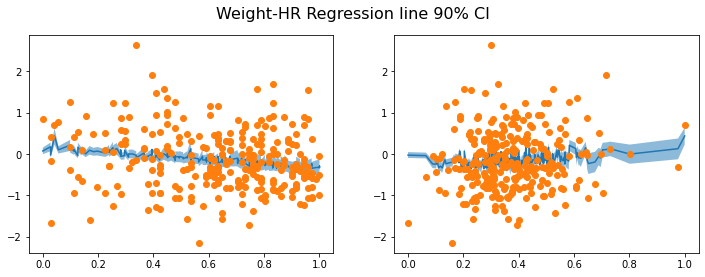

In [30]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "age": x_data[:, 0],
    "weight": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_gt": y_data,
})


predictions = predictions.sort_values(by=['age'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4),)
fig.suptitle("Age-HR Regression line 90% CI", fontsize=16)
ax[0].plot(predictions['age'], predictions['mu_mean'])
ax[0].fill_between(predictions['age'],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(predictions["age"], predictions["y_gt"], "o")
    

predictions = predictions.sort_values(by=['weight'])

fig.suptitle("Weight-HR Regression line 90% CI", fontsize=16)
ax[1].plot(predictions['weight'], predictions['mu_mean'])
ax[1].fill_between(predictions['weight'],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(predictions["weight"], predictions["y_gt"], "o")

Text(0.5, 1.0, 'Weight-HR Regression line 90% CI')

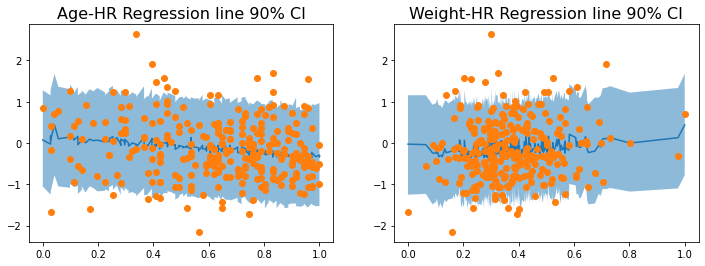

In [34]:
predictions = predictions.sort_values(by=['age'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4),)

ax[0].plot(predictions['age'], predictions['mu_mean'])
ax[0].fill_between(predictions['age'],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
ax[0].plot(predictions["age"], predictions["y_gt"], "o")
ax[0].set_title("Age-HR Regression line 90% CI", fontsize=16)
    

predictions = predictions.sort_values(by=['weight'])


ax[1].plot(predictions['weight'], predictions['mu_mean'])
ax[1].fill_between(predictions['weight'],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
ax[1].plot(predictions["weight"], predictions["y_gt"], "o")
ax[1].set_title("Weight-HR Regression line 90% CI", fontsize=16)

In [ ]:
# Vital Refs

ref_iid = [
    {
        223764: 'HR lying',
        223765: 'HR sitting',
        224647: 'HR standing',
    },
    {
        224645: 'BPs lying',
        224646: 'BPs sitting',
        223766: 'BPs standing',
    },
    {
        226092: 'BPd lying',
        226094: 'BPd sitting',
        226096: 'BPd standing',    
    }
]

denorm_param = {
    0: 220045,
    1: 220179,
    2: 220180,
}
ylim = {
    0: [30, 150]
}


df = df_vs_avg[['weight', 'HR']].copy()
# df['interact'] = df_vs_avg['age'] * df_vs_avg['HR']
# df = df[['age', 'interact', 'HR']]
data = torch.tensor(df.values, dtype=torch.float32)
x_data, y_data = data[:, :-1], data[:, -1]
    
num_iterations=2000

model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))
        
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "weight": x_data[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_gt": y_data,
})

fig, ax = plt.subplots(figsize=(12, 4),)
predictions = predictions.sort_values(by=['weight'])

fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['weight'], predictions['mu_mean'])
ax.fill_between(predictions['weight'],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)
ax.plot(predictions["weight"],
        predictions["y_gt"],
        "o")


fig, ax = plt.subplots(figsize=(12, 4),)
fig.suptitle("Regression line 90% CI", fontsize=16)
ax.plot(predictions['weight'], predictions['y_mean'])
ax.fill_between(predictions['weight'],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
ax.plot(predictions["weight"],
        predictions["y_gt"],
        "o")


        


fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,3)

for j, refs in enumerate(ref_iid):
    for i, iid in enumerate(refs):
        ax = plt.subplot(gs[j,i], sharey=plt.subplot(gs[j,0]))

        x = X_info[iid][:, 0].reshape(-1, 1)
        y = y_ref[iid]
        idx = np.where(np.logical_and(y>np.quantile(y, 0.05), y<np.quantile(y, 0.95)))
        x = x[idx]
        y = y[idx]

    #     reg = LinearRegression().fit(x, y)
        reg = Lasso().fit(x, y)
        x_pred = np.array([X_info[iid][:,0].min(), X_info[iid][:,0].max()]).reshape(-1,1)
        y_pred = reg.coef_[0] * x_pred + reg.intercept_

#         x = denorm_data(X_info[iid][:,0], 'age', info_normalize_param)
#         y = denorm_data(y_ref[iid], 'chart', chart_normalize_param, 220045)
        x = denorm_data(x, 'age', info_normalize_param)
        y = denorm_data(y, 'chart', chart_normalize_param, denorm_param[j])
        x_pred = denorm_data(x_pred, 'age', info_normalize_param)
        y_pred = denorm_data(y_pred, 'chart', chart_normalize_param, denorm_param[j])
        ax.scatter(x, y)
        ax.plot(x_pred, y_pred, c='r')
#         ax.set_ylim([0, 200])

    #     print(reg.score(x, y))

# Gaussian process modeling of trend and seasonality

# Vital responses to pain events

In [3]:
def get_data_near_event(data, event_time, toi_prev=3, toi_post=3, fillna='neighbor'):
    # select subsequence of time series data around the onset of a discrete event
    # toi_prev: time of interest before event in hour
    # toi_post: time of interest after event in hour
    # delta_prev = np.timedelta64(toi_prev, 'h')
    # delta_post = np.timedelta64(toi_post, 'h')
    # begin = event_time - delta_prev
    # end = event_time + delta_post
#     print(type(event_time))
    event_time = pd.to_datetime(event_time)
#     print(type(event_time))
    toi_prev = pd.Timedelta(hours = toi_prev-1)
    toi_post = pd.Timedelta(hours = toi_post)
    begin = event_time.replace(hour=event_time.hour, minute=0, second=0, microsecond=0) - toi_prev
    end = event_time.replace(hour=event_time.hour, minute=0, second=0, microsecond=0) + toi_post
    
    df_ = pd.DataFrame(columns=['charttime', 'valuenum'])
    df_['charttime'] = pd.date_range(begin, end, freq='1H')
    df_['valuenum'] = np.nan
    if type(fillna) == int or type(fillna) == float:
        df_['valuenum'] = fillna

    data = data[(data['charttime']>=begin) & (data['charttime']<=end)]
    if data.shape[0] == 0:
        return df_
    elif data.shape[0] == 1:
#         print(type(data['charttime'].values), data['charttime'].item())
        data_ct = pd.to_datetime(data['charttime'].item())
#         print(type(data_ct))
        data_ct = data_ct.replace(hour=data_ct.hour, minute=0, second=0, microsecond=0) \
                  + pd.Timedelta(hours=data_ct.minute//30)
        df_[df_['charttime']==data_ct] = data['valuenum'].item()
        return df_
    
    ct_, data_ = interpolate_charttime_data(data)

    for ct, d in zip(ct_, data_) :
#         print(d)
        df_.loc[df_['charttime']==ct, 'valuenum'] = d

    if fillna == 'neighbor':
        df_ = df_.fillna(method='ffill')
        df_ = df_.fillna(method='bfill')
    return df_

In [4]:
# pain_severe = ['Moderate to Severe', 'Moderate to Severe.', 
#                'Severe', 'Severe to Worse', 'Worst']
# pain_event = df_chart[(df_chart['itemid']==223791) & (df_chart['value'].isin(pain_severe))]
pain_event = df_chart[(df_chart['itemid']==223791) & (df_chart['valuenum']>=6)]
pain_event

item_selected = pd.concat((item_dict[(item_dict['itemid'].isin(item_vital)) & (item_dict['param_type']=='Numeric')], 
                           item_dict[(item_dict['itemid'].isin(item_resp)) & (item_dict['param_type']=='Numeric')]))
item_selected = item_selected.drop(item_selected.index[-1])

In [5]:
toi_prev = 6
toi_post = 0

vital_cols = item_selected['abbreviation'].tolist()

df_pain = pd.DataFrame(columns=['hadm_id', 'charttime', 'pain_level'] + vital_cols)
for i, (_, event) in enumerate(pain_event.iterrows()):
    adm = event['hadm_id']
    ct = event['charttime']
    df_pain.loc[i, 'hadm_id'] = adm
    df_pain.loc[i, 'charttime'] = ct
    df_pain.loc[i, 'pain_level'] = event['valuenum']
    for _, vital in item_selected.iterrows():
        data_ = df_chart[(df_chart['hadm_id']==adm) & (df_chart['itemid']==vital['itemid'])]
        df_ = get_data_near_event(data_, ct, toi_prev, toi_post, fillna='neighbor')
#         print(df_)
        df_pain.loc[i, vital['abbreviation']] = df_['valuenum'].tolist()

In [6]:
df_pain

,hadm_id,charttime,pain_level,HR,NBPs,NBPd,NBPm,Temperature F,RR,SpO2
0,20002636,2148-02-26 18:00:00,7.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 98.5, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
1,20031565,2128-04-28 20:10:00,9.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
2,20031565,2128-04-30 00:00:00,10.0,"[99.0, 96.0, 93.0, 92.0, 93.0, 88.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[98.9, 98.9, 98.9, 98.9, 98.9, 98.3]","[21.0, 20.0, 19.0, 15.0, 16.0, 16.0]","[99.0, 99.0, 99.0, 98.0, 98.0, 97.0]"
3,20031565,2128-04-30 15:10:00,6.0,"[83.0, 76.0, 75.0, 79.0, 81.0, 83.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 98.2, nan, nan]","[23.0, 27.0, 22.0, 21.0, 10.0, 16.0]","[98.0, 100.0, 100.0, 100.0, 99.0, 99.0]"
4,20041808,2172-06-30 18:40:00,10.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...
892,29551045,2156-08-07 16:37:00,6.0,"[140.0, 145.0, 147.0, 150.0, 149.0, 153.0]","[86.0, 86.0, 107.0, 116.0, 87.0, 96.0]","[65.0, 65.0, 66.0, 64.0, 53.0, 55.0]","[68.0, 68.0, 75.0, 75.0, 62.0, 64.0]","[98.7, 98.7, 98.7, 98.7, 98.7, 99.0]","[20.0, 29.0, 27.0, 35.0, 27.0, 37.0]","[95.0, 98.0, 96.0, 96.0, 96.0, 94.0]"
893,29551045,2156-08-07 21:00:00,6.0,"[153.0, 144.0, 162.0, 151.0, 149.0, 153.0]","[96.0, 87.0, 116.0, 115.0, 115.0, 115.0]","[55.0, 49.0, 59.0, 57.0, 57.0, 57.0]","[64.0, 59.0, 70.0, 72.0, 72.0, 72.0]","[99.0, 99.0, 99.0, 99.0, 98.2, 98.2]","[37.0, 26.0, 30.0, 29.0, 21.0, 25.0]","[94.0, 94.0, 93.0, 95.0, 95.0, 95.0]"
894,29728210,2141-04-26 01:33:00,6.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[97.8, 97.8, 97.8, 97.8, 97.6, 97.6]","[18.0, 18.0, 18.0, 18.0, 21.0, 21.0]","[nan, nan, nan, nan, nan, nan]"
895,29728210,2141-04-27 05:27:00,7.0,"[77.0, 77.0, 75.0, 75.0, 75.0, 75.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[97.6, 97.6, 97.6, 97.6, 98.2, 98.2]","[13.0, 13.0, 19.0, 19.0, 18.0, 18.0]","[95.0, 95.0, 94.0, 94.0, 95.0, 95.0]"


In [66]:
def interpolate_charttime_df(df, freq='1H'):
    df_interp = pd.DataFrame(columns=['hadm_id', 'charttime', 'itemid', 'valuenum'])
    for adm in df['hadm_id'].unique():
        for iid in df['itemid'].unique():
            df_ = pd.DataFrame(columns=df_interp.columns)
            data = df[(df['hadm_id']==adm) & (df['itemid']==iid)]
            
            x_dt = data['charttime'].values
            x = get_unixtime(x_dt)
            y = data['valuenum'].values

            f_interp = interp1d(x, y, kind='previous', fill_value=np.nan, bounds_error=False)
            
            start = pd.to_datetime(x_dt[0])
            delta_h = pd.Timedelta(hours=start.minute//30)
            start = start.replace(hour=start.hour, minute=0, second=0, microsecond=0) + delta_h
#             print(start)
            x_dt_ = np.array(pd.date_range(start, x_dt[-1], freq=freq).to_pydatetime(), dtype=np.datetime64)
            x_ = get_unixtime(x_dt_)
            y_ = f_interp(x_)
            
            df_['charttime'] = x_dt_
            df_['valuenum'] = y_
            df_['hadm_id'] = adm
            df_['itemid'] = iid
            
            df_['valuenum'] = df_['valuenum'].fillna(method='ffill')
            df_['valuenum'] = df_['valuenum'].fillna(method='bfill')
            df_interp = pd.concat((df_interp, df_), ignore_index=True)
            
            df_interp['charttime'] = pd.to_datetime(df_interp['charttime'])
        
    return df_interp

In [67]:
len_seg = 6

adm_ts_normal = []
for adm in df_info['hadm_id'].unique():
    data = df_chart[(df_chart['hadm_id']==adm) & (df_chart['itemid'].isin(item_selected['itemid']))].copy()
    data = interpolate_charttime_df(data)
    
    for ct_pain in pain_event[pain_event['hadm_id']==adm]['charttime']:
#         print(ct_pain)
        delta_t = pd.Timedelta(hours = len_seg)
        data.drop(data[(data['charttime']>=ct_pain-delta_t) & (data['charttime']<=ct_pain+delta_t)].index,
                  inplace=True)
        list_of_data = [d for _, d in data.groupby(['itemid', data.index - np.arange(len(data))])]
        list_of_data = [d for d in list_of_data if d.shape[0] >= len_seg]
        list_of_data = [d.drop(d.index[-len_seg+1:]) for d in list_of_data]
#         for d in list_of_data:
#             d.drop(d.index[-len_seg+1:], inplace=True)

        ts_list = [list(d['charttime']) for d in list_of_data]
        ts_list = [ts for l in ts_list for ts in l]
        ts_count = {ts:ts_list.count(ts) for ts in ts_list}
        
        for ts in set(ts_list):
            if ts_count[ts] < 5: # valid signal sources
                del ts_count[ts]
        adm_ts_normal += [(adm, ts) for ts in ts_count]

In [71]:
len(adm_ts_normal), pain_event.shape

(125214, (897, 10))

In [80]:
df_normal = pd.DataFrame(columns=df_pain.columns)
idx_normal = np.random.choice(range(len(adm_ts_normal)), pain_event.shape[0], replace=False)

for i, idx in enumerate(idx_normal):
    adm, ct = adm_ts_normal[idx]
    df_normal.loc[i, 'hadm_id'] = adm
    df_normal.loc[i, 'charttime'] = ct
    df_normal.loc[i, 'pain_level'] = 0
    for _, vital in item_selected.iterrows():
        data_ = df_chart[(df_chart['hadm_id']==adm) & (df_chart['itemid']==vital['itemid'])]
        df_ = get_data_near_event(data_, ct, toi_prev, toi_post, fillna='neighbor')
        df_normal.loc[i, vital['abbreviation']] = df_['valuenum'].tolist() 


In [ ]:
df_chart

In [81]:
df_normal

,hadm_id,charttime,pain_level,HR,NBPs,NBPd,NBPm,Temperature F,RR,SpO2
0,22625448,2154-09-29 07:00:00,0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
1,28139062,2162-11-19 07:00:00,0,"[87.0, 79.0, 78.0, 79.0, 81.0, 86.0]","[126.0, 97.0, 108.0, 94.0, 100.0, 95.0]","[77.0, 66.0, 63.0, 69.0, 64.0, 55.0]","[92.0, 77.0, 78.0, 78.0, 75.0, 68.0]","[nan, nan, 98.9, nan, nan, nan]","[19.0, 16.0, 15.0, 14.0, 15.0, 22.0]","[nan, nan, nan, nan, nan, nan]"
2,20510894,2169-07-23 03:00:00,0,"[99.0, 92.0, 95.0, 97.0, 91.0, 103.0]","[nan, nan, nan, 101.0, nan, nan]","[nan, nan, nan, 65.0, nan, nan]","[nan, nan, nan, 76.0, nan, nan]","[nan, nan, 97.3, nan, nan, nan]","[25.0, 18.0, 19.0, 18.0, 18.0, 16.0]","[100.0, 99.0, 99.0, 99.0, 99.0, 99.0]"
3,25520844,2187-03-28 13:00:00,0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
4,28139062,2162-11-17 02:00:00,0,"[71.0, 89.0, 72.0, 69.0, 72.0, 71.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 98.7, nan, nan]","[20.0, 26.0, 18.0, 18.0, 15.0, 17.0]","[95.0, 90.0, 93.0, 93.0, 94.0, 93.0]"
...,...,...,...,...,...,...,...,...,...,...
892,27219490,2117-11-14 11:00:00,0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
893,28139062,2162-11-26 15:00:00,0,"[68.0, 67.0, 61.0, 69.0, 76.0, 68.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, 98.1, nan, nan, nan]","[20.0, 20.0, 34.0, 23.0, 17.0, 9.0]","[96.0, 98.0, 97.0, 98.0, 98.0, 96.0]"
894,24646557,2155-06-07 22:00:00,0,"[76.0, 75.0, 75.0, 75.0, 75.0, 75.0]","[81.0, 75.0, 76.0, 105.0, 90.0, 84.0]","[51.0, 43.0, 46.0, 62.0, 51.0, 55.0]","[58.0, 50.0, 53.0, 72.0, 61.0, 62.0]","[nan, nan, nan, 98.5, nan, nan]","[15.0, 21.0, 19.0, 17.0, 21.0, 19.0]","[95.0, 95.0, 91.0, 91.0, 96.0, 96.0]"
895,25520844,2187-03-24 04:00:00,0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"


In [72]:
df_pain

,hadm_id,charttime,pain_level,HR,NBPs,NBPd,NBPm,Temperature F,RR,SpO2
0,20002636,2148-02-26 18:00:00,7.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 98.5, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
1,20031565,2128-04-28 20:10:00,9.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
2,20031565,2128-04-30 00:00:00,10.0,"[99.0, 96.0, 93.0, 92.0, 93.0, 88.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[98.9, 98.9, 98.9, 98.9, 98.9, 98.3]","[21.0, 20.0, 19.0, 15.0, 16.0, 16.0]","[99.0, 99.0, 99.0, 98.0, 98.0, 97.0]"
3,20031565,2128-04-30 15:10:00,6.0,"[83.0, 76.0, 75.0, 79.0, 81.0, 83.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 98.2, nan, nan]","[23.0, 27.0, 22.0, 21.0, 10.0, 16.0]","[98.0, 100.0, 100.0, 100.0, 99.0, 99.0]"
4,20041808,2172-06-30 18:40:00,10.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...
892,29551045,2156-08-07 16:37:00,6.0,"[140.0, 145.0, 147.0, 150.0, 149.0, 153.0]","[86.0, 86.0, 107.0, 116.0, 87.0, 96.0]","[65.0, 65.0, 66.0, 64.0, 53.0, 55.0]","[68.0, 68.0, 75.0, 75.0, 62.0, 64.0]","[98.7, 98.7, 98.7, 98.7, 98.7, 99.0]","[20.0, 29.0, 27.0, 35.0, 27.0, 37.0]","[95.0, 98.0, 96.0, 96.0, 96.0, 94.0]"
893,29551045,2156-08-07 21:00:00,6.0,"[153.0, 144.0, 162.0, 151.0, 149.0, 153.0]","[96.0, 87.0, 116.0, 115.0, 115.0, 115.0]","[55.0, 49.0, 59.0, 57.0, 57.0, 57.0]","[64.0, 59.0, 70.0, 72.0, 72.0, 72.0]","[99.0, 99.0, 99.0, 99.0, 98.2, 98.2]","[37.0, 26.0, 30.0, 29.0, 21.0, 25.0]","[94.0, 94.0, 93.0, 95.0, 95.0, 95.0]"
894,29728210,2141-04-26 01:33:00,6.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[97.8, 97.8, 97.8, 97.8, 97.6, 97.6]","[18.0, 18.0, 18.0, 18.0, 21.0, 21.0]","[nan, nan, nan, nan, nan, nan]"
895,29728210,2141-04-27 05:27:00,7.0,"[77.0, 77.0, 75.0, 75.0, 75.0, 75.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[97.6, 97.6, 97.6, 97.6, 98.2, 98.2]","[13.0, 13.0, 19.0, 19.0, 18.0, 18.0]","[95.0, 95.0, 94.0, 94.0, 95.0, 95.0]"


In [58]:
df_pain[df_pain['pain_level']==10]

,hadm_id,charttime,pain_level,HR,NBPs,NBPd,NBPm,Temperature F,RR,SpO2
2,20031565,2128-04-30 00:00:00,10.0,"[92.0, 93.0, 88.0, 93.0, 75.0, 70.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, 98.3, nan, nan, nan]","[15.0, 16.0, 16.0, 21.0, 17.0, 12.0]","[98.0, 98.0, 97.0, 99.0, 100.0, 98.0]"
4,20041808,2172-06-30 18:40:00,10.0,"[75.0, 79.0, 109.0, 109.0, 109.0, 103.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[20.0, 33.0, 28.0, 33.0, 31.0, 21.0]","[100.0, 100.0, 100.0, 97.0, 100.0, 96.0]"
23,20312271,2177-07-07 06:00:00,10.0,"[62.0, 65.0, 77.0, 77.0, 65.0, 65.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[98.0, 98.0, 98.0, 98.0, 98.6, 98.6]","[9.0, 15.0, 18.0, 18.0, 11.0, 11.0]","[96.0, 99.0, 96.0, 96.0, 96.0, 96.0]"
33,20510894,2169-07-11 08:15:00,10.0,"[88.0, 88.0, 89.0, 80.0, 80.0, 80.0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, 98.3, nan, nan, nan]","[23.0, 23.0, 17.0, 17.0, 17.0, 17.0]","[100.0, 100.0, 100.0, 96.0, 96.0, 96.0]"
63,20966929,2120-07-04 10:37:00,10.0,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 97.9, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...
863,29376660,2172-10-20 12:00:00,10.0,"[83.0, 84.0, 89.0, 87.0, 86.0, 91.0]","[93.0, 92.0, 98.0, 89.0, 98.0, 111.0]","[53.0, 51.0, 53.0, 60.0, 50.0, 58.0]","[62.0, 61.0, 64.0, 67.0, 62.0, 70.0]","[nan, nan, 99.8, nan, nan, nan]","[22.0, 17.0, 29.0, 22.0, 16.0, 19.0]","[98.0, 98.0, 97.0, 96.0, 96.0, 96.0]"
869,29376660,2172-10-21 11:00:00,10.0,"[nan, nan, nan, nan, nan, nan]","[138.0, 138.0, 159.0, 144.0, 137.0, 135.0]","[67.0, 67.0, 76.0, 69.0, 69.0, 69.0]","[84.0, 84.0, 94.0, 86.0, 83.0, 86.0]","[99.2, 99.2, 99.2, 98.7, 98.7, 98.7]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
873,29376660,2172-10-22 08:00:00,10.0,"[84.0, 87.0, 81.0, 93.0, 87.0, 89.0]","[137.0, 137.0, 126.0, 124.0, 104.0, 109.0]","[74.0, 74.0, 70.0, 56.0, 56.0, 52.0]","[88.0, 88.0, 83.0, 71.0, 67.0, 67.0]","[nan, nan, 98.5, nan, nan, nan]","[46.0, 29.0, 23.0, 20.0, 18.0, 15.0]","[98.0, 98.0, 96.0, 98.0, 98.0, 98.0]"
874,29376660,2172-10-22 11:00:00,10.0,"[93.0, 87.0, 89.0, 84.0, 85.0, 85.0]","[124.0, 104.0, 109.0, 112.0, 119.0, 124.0]","[56.0, 56.0, 52.0, 61.0, 61.0, 62.0]","[71.0, 67.0, 67.0, 73.0, 75.0, 76.0]","[nan, nan, nan, 99.3, nan, nan]","[20.0, 18.0, 15.0, 16.0, 21.0, 18.0]","[98.0, 98.0, 98.0, 99.0, 98.0, 99.0]"


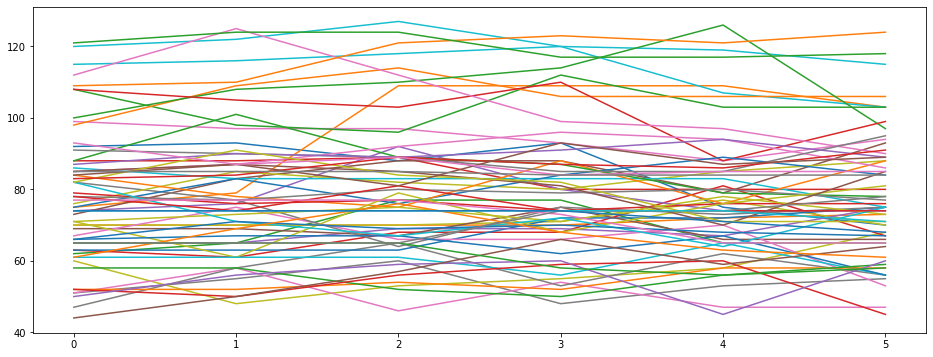

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for _, pain in df_pain[df_pain['pain_level']==10].iterrows():
    ax.plot(pain['HR'])

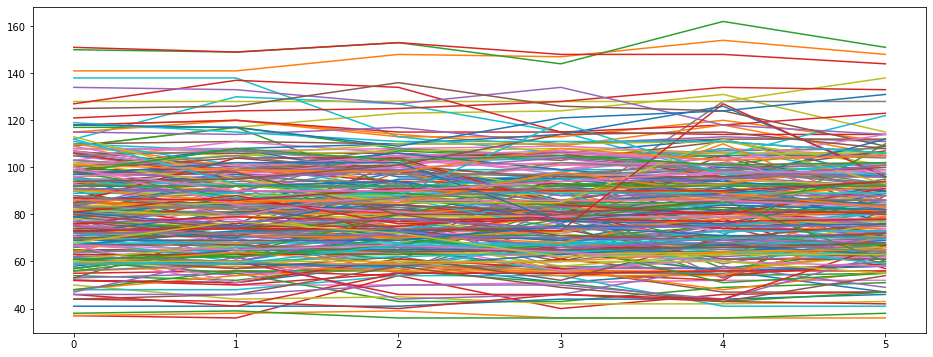

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for _, pain in df_pain[df_pain['pain_level']==6].iterrows():
    ax.plot(pain['HR'])